# V1.0
## Szenario-basierte Berechnungen für Energieverbrauchs- und Erzeugungsentwicklung bis 2030

In diesem Notebook führen wir Szenario-basierte Berechnungen für die Entwicklung von Energieverbrauch und -produktion durch.

## Importieren der Bibliotheken

Wir beginnen mit dem Importieren der erforderlichen Bibliotheken, einschließlich `pandas` für die Datenverarbeitung und `matplotlib` für die Visualisierung.

In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import os
from pathlib import Path
from datetime import datetime

### selbstgeschriebene Utils
Für bessere Übersicht wurden Funktionen in Python-Skripte ausgelagert und werden hier importiert, damit sie später im Code aufgerufen werden können.

In [2]:
# eigene Utils
from utils.addTimeInformation import addTimeInformation
from utils.combineDataFrames import combineDataFrames
from utils.extraploation_class import Extrapolation
from utils.plotCalendarHeatmap import plotCalendarHeatmap
from utils.read_CSV import *
from utils.calcDifference import differenceBetweenDataframes
from utils.calculateConsumption import calculateConsumption, getConsumptionYear
from utils.plotResidualDiagram import plotResidualDiagram
from utils.plotWeekDiagram import plotWeekDiagramm
from utils.determinePerformanceSzenarios import determinePerformanceSzenarios
from utils.performance_factors import performance_factors
from utils.addTimePerformance import addTimePerformance
from utils.dunkelflautePerformanceFactor import dunkelflautePerformanceFactor
from utils.load_profile_heat_pump import load_profile_heatpump

## Szenarien-Definition
Das Programm rechnet mit Variablen für `Verbrauchsentwicklung`, `PV-Leistung`, `Wind-Leistung (Onshore)` und `Windleistung (Onshore)`

Zu Beginn wird festgelegt, welches Szenario gerechnet werden soll, je nachdem werden die eben genannten Variablen festgesetzt. Die Werte für die Szenarien wurden aus den Big5-Studien ermittelt.

In [ ]:
# Faktoren, Variablen

#consumption_development_rate = 1.045
consumption_development_per_year = {
    2024: 1.045,
    2025: 1.03,
    2026: 1.0335,
    2027: 1.066,
    2028: 0.89,
    2029: 1.09,
    2030: 1.02
}
onshore_development_rate = 1.129
offshore_development_rate = 1.066
pv_development_rate = 1.131
CO2_factor_Kohle = 0.35
CO2_factor_Gas = 0.2
share_coal = (100/39*23)/100
share_gas = (100/39*16)/100
IST_installierte_waermepumpen = 1400000;
SOLL_installierte_waermepumpen = 5999000;

## CSV einlesen (Erzeugung)
Wir lesen die SMARD-Daten für realisierte Erzeugung (2015-2023).
Ist das abgeschlossen, werden die Daten ab 2024 bis 2030 extrapoliert und in einem Dataframe gespeichert, dass Daten für alle Jahre enthält.

In [4]:
#alle Daten ab 2015 einlesen
directory_yearly_generation = getData("Generation")

# Daten extrapolieren 2024 bis 2030
for year in range(2024,2031):
    prev_year_df =directory_yearly_generation.get(year-1).copy()    #Kopie des Dataframe des letzten Jahres
    extrapolated_data = Extrapolation(prev_year_df, year, onshore_development_rate, offshore_development_rate, pv_development_rate)        #Erstellung eines neuen Objekts, mit einem DataFrame
    directory_yearly_generation[extrapolated_data.year]= extrapolated_data.df   #DataFrame in das Erzeugungsverzeichnis gespeichert wird




Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


## PerformanceFaktoren(2015-2023):

Erstellung von Performance Faktoren um Wetterabhängigkeit zu implementiern und erzeugte Energie anhand der Installierten Leistung abzuleiten


In [5]:

directory_yearly_installed = getData("Installed")
directory_yearly_performance = performance_factors(directory_yearly_generation, directory_yearly_installed)
directory_szenarios=determinePerformanceSzenarios(directory_yearly_performance)
directory_szenarios["WorstCase"].to_csv("WorstCase.csv")
directory_szenarios["BestCase"]= addTimePerformance(directory_szenarios["BestCase"], 2030)
dunkelflautePerformanceFactor(directory_yearly_performance)


Data für 2015 loaded succsessfully.
Data für 2016 loaded succsessfully.
Data für 2017 loaded succsessfully.
Data für 2018 loaded succsessfully.
Data für 2019 loaded succsessfully.
Data für 2020 loaded succsessfully.
Data für 2021 loaded succsessfully.
Data für 2022 loaded succsessfully.
Data für 2023 loaded succsessfully.


/Users/private/Desktop/Projects/Klimaneutral-20245/utils/determinePerformanceSzenarios.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  meanPerformanceFactors = pd.concat([meanPerformanceFactors, pd.DataFrame([{"Jahr": year, "Photovoltaik": meanPV, "Wind Onshore": meanOnshore, "Wind Offshore": meanOffshore}])], ignore_index=True)


Es lag eine Dunkelflaute vom 2015-01-18 14:45:00 bis zum 2015-01-21 14:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2021-01-06 23:45:00 bis zum 2021-01-09 23:30:00 vor Anzahl Viertelstunden: 288
Es lag eine Dunkelflaute vom 2022-11-29 01:30:00 bis zum 2022-12-02 01:15:00 vor Anzahl Viertelstunden: 288


In [6]:
##Lastprofile
#Lastprofil Wärmepumpe

In [ ]:
direcoty_heatpump_comsumption = load_profile_heatpump(IST_installierte_waermepumpen,SOLL_installierte_waermepumpen,2024,2030)




## Erzeugung 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch die Gesamtsumme der EE-Erzeugung enthält (15-Min-AUflösung).

In [8]:
# Lade die Daten für das Jahr 2030
df_2030 = directory_yearly_generation.get(2030)

# Überprüfe, ob die Spalten vorhanden sind
required_columns = ['Wind Offshore', 'Wind Onshore', 'Photovoltaik']
if all(column in df_2030.columns for column in required_columns):
    # Berechne die Summe der gewünschten Spalten für jede 15-Minuten-Periode
    df_2030['Gesamterzeugung_EE'] = df_2030[required_columns].sum(axis=1)
    
    # Speichere die Ergebnisse in production_2030
    production_2030 = df_2030[['Datum', 'Gesamterzeugung_EE']]
    
    #print(production_2030)
else:
    print("Eine oder mehrere der erforderlichen Spalten fehlen im DataFrame für 2030.")

# Verbrauch 2030 (Gesamt)

Wir erstellen ein neues Dataframe nur für 2030, das nun zusätzlich auch den Gesamtverbrauch enthält (15-Min-AUflösung).

In [9]:
consumption_existing_years = calculateConsumption(consumption_development_per_year)
consumption_2030 = consumption_existing_years.get(2030)

print(consumption_2030)

Data für 2023 loaded succsessfully.
                    Datum  Gesamtverbrauch  Year      Time Month Year Month  \
0     2030-01-01 00:00:00     11127.533058  2030  00:00:00   Jan    2030 01   
1     2030-01-01 00:15:00     11036.078610  2030  00:15:00   Jan    2030 01   
2     2030-01-01 00:30:00     10999.841941  2030  00:30:00   Jan    2030 01   
3     2030-01-01 00:45:00     10948.650458  2030  00:45:00   Jan    2030 01   
4     2030-01-01 01:00:00     10851.731750  2030  01:00:00   Jan    2030 01   
...                   ...              ...   ...       ...   ...        ...   
35035 2030-12-31 22:45:00     12401.855889  2030  22:45:00   Dec    2030 12   
35036 2030-12-31 23:00:00     12369.070332  2030  23:00:00   Dec    2030 12   
35037 2030-12-31 23:15:00     12200.253473  2030  23:15:00   Dec    2030 12   
35038 2030-12-31 23:30:00     12072.274764  2030  23:30:00   Dec    2030 12   
35039 2030-12-31 23:45:00     11835.010865  2030  23:45:00   Dec    2030 12   

      Year Mont

# Differenz bilden

Wir bestimmen die Resiudallast als Differenz zwischen Verbrauch und Erzeugung für die 2030-Dataframes.
Damit können wir den Anteil nicht-EE-Energie bestimmen an der Gesamtenergieerzeugung, der Anteil soll abnehmen.

In [10]:
# Annahme: consumption_2030 und production_2030 sind bereits definierte DataFrames mit einer 'Datum'-Spalte und einer 'Gesamtverbrauch'-Spalte

# Überprüfe, ob beide DataFrames die gleiche Zeitachse haben

#print(production_2030)
def differenceBetweenDataframes(df1, df2):
    

    # Vergleichen der Spalten elementweise
    #comparison = df1['Datum'] == df2['Datum']
    #print("Vergleich der Spalten:", comparison)

    # Finden der Unterschiede
    #differences = df1['Datum'][~comparison]
    #print("Unterschiede in df1['Datum']:", differences)

    #differences = df2['Datum'][~comparison]
    #print("Unterschiede in df2['Datum']:", differences)

    print("df1:", df1.loc[28904, 'Datum'])
    print("df2:", df2.loc[28904, 'Datum'])
    print("df1:", df1.loc[28905, 'Datum'])
    print("df2:", df2.loc[28905, 'Datum'])

    
    if df1['Datum'].equals(df2['Datum']):
        print("Die Zeitachsen der DataFrames stimmen überein.")
        # Berechne die Differenz zwischen Verbrauch und Produktion
        difference_df = pd.DataFrame()
        difference_df['Datum'] = df1['Datum']
        difference_df['Differenz'] =  df1['Gesamtverbrauch']- df2['Gesamterzeugung_EE']

        difference_df['Year Month'] = difference_df['Datum'].dt.strftime('%Y %m')
        difference_df['Day'] = difference_df['Datum'].dt.strftime('%d')
        
        #print(difference_df)
        return difference_df
    else:
        #print("Die Zeitachsen der DataFrames stimmen nicht überein.")
        return None

resdidual_df = differenceBetweenDataframes(consumption_2030, production_2030)

#print(resdidual_df)

df1: 2030-10-29 02:00:00
df2: 2030-10-29 02:30:00
df1: 2030-10-29 02:15:00
df2: 2030-10-29 02:30:00


# Auswertung
Um die Daten besser zu verstehen, plotten wir verschiedene Diagramme in unterschiedlicher Auflösung (15min - jährlich) für verschiedene Kennzahlen.
- Heatmap für ein Jahr
- Summenhistogramm für ein Jahr
- Residuallast über die Jahre bis 2030
- Wochendiagramm für den Vergleich von Verbrauch und Erzeugung

## HeatMap

Für das Jahr 2030 plotten wir eine Heatmap: Grüne Flächen bedeuten eine gute Abdeckung des Verbrauchs durch EE-Energie, rote Flächen zeigen Defizite in der EE-Versorgung.

In [11]:
#plotCalendarHeatmap(resdidual_df, "Überschüssige/Restbedarf Energie", "Differenz", linewidths = 0)

## Summenhistogramm
Zusätzlich wird ein Summendiagramm erstellt, das die Anzahl der zu 80% durch EE-Energie gedeckten 15-Minuten aufzeigt.

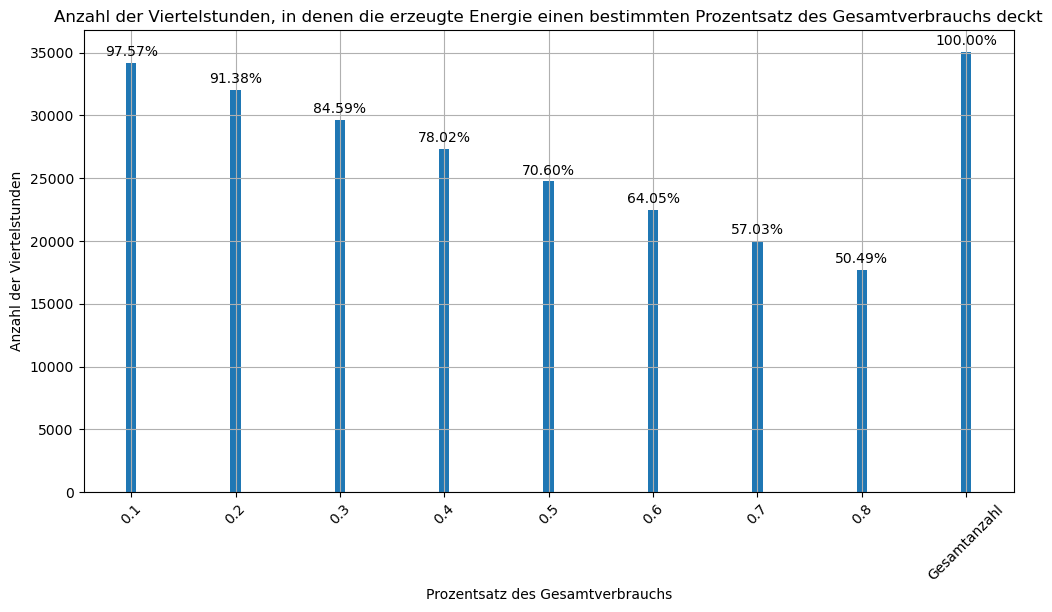

In [12]:

# Prozentsätze definieren
percentages = [0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

# Dictionary, um die Anzahl der Viertelstunden für jeden Prozentsatz zu speichern
coverage_counts = {percentage: 0 for percentage in percentages}

# Berechne die Deckung für jede Viertelstunde
for index, row in production_2030.iterrows():
    for percentage in percentages:
        if row['Gesamterzeugung_EE'] >= percentage * consumption_2030.loc[index, 'Gesamtverbrauch']:
            coverage_counts[percentage] += 1

# Füge die Gesamtanzahl der Viertelstunden hinzu
total_quarters = len(production_2030)
coverage_counts['Gesamtanzahl'] = total_quarters

# Erstelle ein Summenhistogramm
plt.figure(figsize=(12, 6))
# Convert keys to strings for consistent data types
coverage_counts_str_keys = {str(key): value for key, value in coverage_counts.items()}

bars = plt.bar(coverage_counts_str_keys.keys(), coverage_counts_str_keys.values(), width=0.10, align='center')

# Annotate bars with percentage of total quarters
for bar in bars:
    height = bar.get_height()
    percentage = (height / total_quarters) * 100
    plt.annotate(f'{percentage:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.xlabel('Prozentsatz des Gesamtverbrauchs')
plt.ylabel('Anzahl der Viertelstunden')
plt.title('Anzahl der Viertelstunden, in denen die erzeugte Energie einen bestimmten Prozentsatz des Gesamtverbrauchs deckt')
plt.xticks([str(key) for key in coverage_counts.keys()], rotation=45)
plt.grid(True)
plt.show()

## Diagramm für Residuallast (Differenz zw. EE-Erzeugung und Verbrauch)

**positive Differenz (Erzeugung > Verbrauch)**<br>
Hinweis auf eine Überschussproduktion, die EE-Erzeugung deckt den Verbrauch vollkommen und darüber hinaus. Der erzeugte Strom kann nicht vollständig verwendet werden (Exportmöglichkeit).

**negative Differenz (Erzeugung < Verbrauch)**<br>
Der Verbrauch ist höher als die EE-Erzeugung und kann also nicht abgedeckt werden. EE müssen ausgebaut werden.

**Trend**<br>
Die Differenz kann bei höherer Auflösung betrachtet evtl. schwanken -> saisonale Unterschiede in Produktionsmöglichkeiten für EE (bsp. im Winter weniger Sonne).
Ein positiver langfristiger Trend könnte auf eine erfolgreiche Integration erneuerbarer Energien hinweisen, während ein negativer langfristiger Trend auf Herausforderungen bei der Deckung des Energiebedarfs durch erneuerbare Energien hinweisen könnte.


In [13]:
#plotResidualDiagram(2023, 2030, directory_yearly_generation, consumption_existing_years)

## Wochendiagramm: Vergleich Verbrauch Erzeugung/Verbrauch, 15min

/Users/private/Desktop/Projects/Klimaneutral-20245/utils/plotWeekDiagram.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])
/Users/private/Desktop/Projects/Klimaneutral-20245/utils/plotWeekDiagram.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week_consumption_df['Datum'] = pd.to_datetime(week_consumption_df['Datum'])


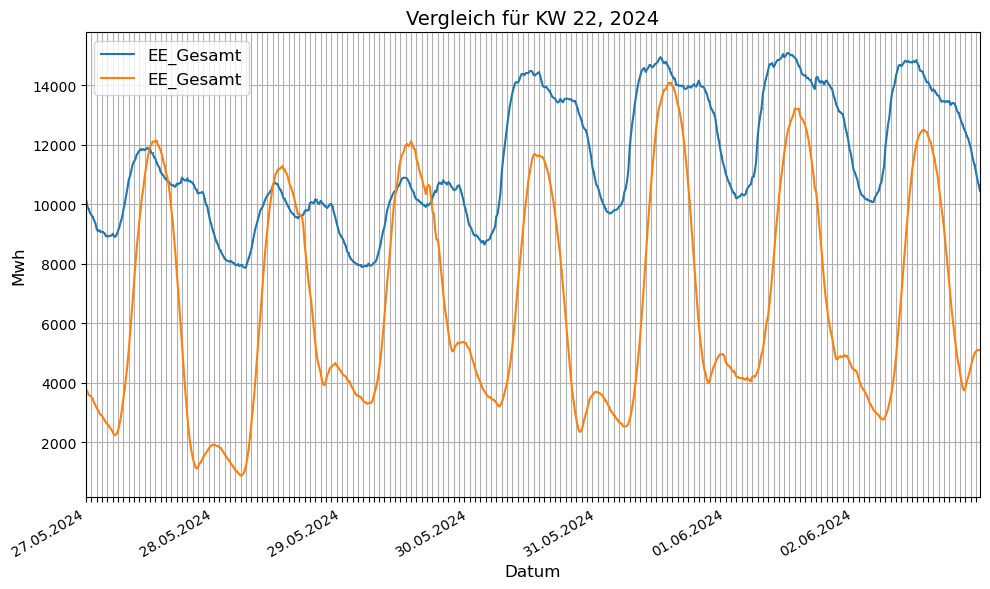

In [14]:
selected_week = '22'
selected_year = '2024'



# didirectory_yearly_generation and consumption_existing_years are dicitionaries

plotWeekDiagramm(selected_week, selected_year, consumption_existing_years, directory_yearly_generation)

# CO2-Bilanz bilden

Wir untersuchen weiterhin die Residuallast - die hier verbleibenden MWh geben uns Auskunft über die verbleibenden CO2-Emissionen. Ist die Resiudalllast = 0, sind auch die Emissionen auf 0T gesunken.
Die Emissionen werden pro fossielem Energieträger (Kohle und Gas) berechnet. Eine MWH hat je Energieträger produziert spezifische Werte CO2-Tonnen, diese werden aufsummiert.


In [15]:
#Summiere die Differenz der Viertelstunden
total_residual_energy = (resdidual_df['Differenz'].sum())

print(f"Insgesamt müssen {total_residual_energy/1000} GWh über fossile Brennstoffe erzeugt werden.")

if total_residual_energy > 0:
    total_residual_energy_CO2_Kohle = total_residual_energy * CO2_factor_Kohle * share_coal
    total_residual_energy_CO2_gas = total_residual_energy * CO2_factor_Gas * share_gas 
    total_co2 = total_residual_energy_CO2_Kohle + total_residual_energy_CO2_gas
    print("Es werden insgesamt {} Tonnen CO2 emittiert. Davon sind {} Tonnen CO2 aus Kohle und {} Tonnen CO2 aus Gas.".format(total_co2, total_residual_energy_CO2_Kohle, total_residual_energy_CO2_gas))
elif total_residual_energy < 0:
    print("Es wird kein CO2 emittiert.")
else:
    print("Es liegt ein Fehler in der Berechnung vor.") 

TypeError: 'NoneType' object is not subscriptable

# User-Info